In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import random
import json
import torch
from convexlocalisometry.vendor import HParams
from convexlocalisometry.atomic_geometry import get_atoms3_full, get_atoms4_full, get_atoms_4
import itertools

print('Loading ethanol data')

config_path = "/Users/samsonkoelle/montlake/experiments/configs/ethanol_full.json"
raw_data = "/Users/samsonkoelle/thesis_data/raw_data/ethanol.mat"

positions = np.load('/Users/samsonkoelle/positions.npy')
randomindices = np.load('/Users/samsonkoelle/indices.npy')

np.random.seed(1234)
random.seed(1234)

config = {}

with open(config_path) as f:
    config.update(json.load(f))

hparams = HParams(**config)

Loading ethanol data


In [2]:
d = hparams.d
n_components = hparams.n_components
atoms2_feat = hparams.atoms2_feat
atoms3_feat = hparams.atoms3_feat
atoms4_feat = hparams.atoms4_feat
atoms2_dict = hparams.atoms2_dict
atoms3_dict = hparams.atoms3_dict
atoms4_dict = hparams.atoms4_dict
diagram = hparams.diagram

ii = np.asarray(hparams.ii)
jj = np.asarray(hparams.jj)
#load geometric features
natoms = positions.shape[1]
n = positions.shape[0]
atoms2 = np.asarray(list(itertools.combinations(range(natoms), 2)))
atoms2full = atoms2
atoms3 = np.asarray(list(itertools.combinations(range(natoms), 3)))
atoms4 = np.asarray(list(itertools.combinations(range(natoms), 4)))
atoms3full = get_atoms3_full(atoms3)
atoms4full = get_atoms4_full(atoms4)

if atoms2_feat:
    atoms2_feats = atoms2full
else:
    atoms2_feats = np.asarray([])

if atoms3_feat:
    atoms3_feats = atoms3full
else:
    atoms3_feats = np.asarray([])

if atoms4_feat:
    atoms4_feats = atoms4full
else:
    atoms4_feats = np.asarray([])

In [3]:
data = np.load('/Users/samsonkoelle/ethanolanglesfull_0524.npy')
n_neighbors = hparams.n_neighbors
atoms4_dicts= get_atoms_4(natoms, ii, jj)[0]
if atoms2_dict:
    atoms2_dicts = atoms2full
else:
    atoms2_dicts = np.asarray([])
if atoms3_dict:
    atoms3_dicts = atoms3full
else:
    atoms3_dicts = np.asarray([])


In [4]:
from scipy import sparse
from convexlocalisometry.transformation import exponential_transformation
from convexlocalisometry.manifold import local_pca
from convexlocalisometry.atomic_geometry import get_D_feats_feats

nsel = 100
dimension = 2
p = atoms4full.shape[0]

selected_points = np.random.choice(range(50000),nsel)
dg_x = np.asarray([get_D_feats_feats(positions[selected_points[i]],
           atoms2in = atoms2_feats,
           atoms3in = atoms3_feats,
           atoms4in = atoms4_feats,
           atoms2out = atoms2_dicts,
           atoms3out = atoms3_dicts,
           atoms4out = atoms4full) for i in range(nsel)])                           

power = 1


/Users/samsonkoelle/miniconda3/envs/isometry/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [5]:
dg_M = np.zeros((nsel, dimension, p))
for i, sp in enumerate(selected_points):
    tangent_bases = local_pca(data, sp, n_neighbors, dimension)
    # NOTE (Sam): normalization prior to projection once again in the manifold case.
    dg_x_normalized = exponential_transformation(dg_x[i], power)
    dg_M[i] = np.einsum('b p, b d -> d p', dg_x_normalized, tangent_bases)

In [6]:
from convexlocalisometry.algorithm import greedy, group_basis_pursuit, brute
from convexlocalisometry.loss import isometry_loss
from tqdm import tqdm

In [7]:
losses = []
two_stage_losses = []
random_two_stage_losses= []
nbp = []

for i in tqdm(range(100)):
    X = dg_M[i]
    output = greedy(X, isometry_loss, dimension, []) # plainly brute is too hard 178**13 combinations
    loss = isometry_loss(X[:,output])
    losses.append(loss)
    data_transformed = exponential_transformation(X)
    beta = group_basis_pursuit(data_transformed)
    basis_pursuit_indices = np.where(np.linalg.norm(beta, axis = 1))[0]
    nbp.append(len(basis_pursuit_indices))

    two_stage_output = basis_pursuit_indices[np.asarray(brute(X[:,basis_pursuit_indices], isometry_loss, dimension))] # plainly this is too hard 178**13 combinations
    two_stage_loss = isometry_loss(X[:,two_stage_output])
    two_stage_losses.append(two_stage_loss)
    random_indices = np.random.choice(range(X.shape[1]), len(basis_pursuit_indices), replace=False)
    random_two_stage_losses.append(isometry_loss(X[:,random_indices]))

  0%|                                                                                                 | 0/100 [00:00<?, ?it/s]/Users/samsonkoelle/convexlocalisometry/convexlocalisometry/loss.py:14: RuntimeWarning: overflow encountered in exp
  (np.exp(singular_values) + np.exp(singular_values ** (-1))) / (2 * np.e)
/Users/samsonkoelle/convexlocalisometry/convexlocalisometry/transformation.py:27: RuntimeWarning: overflow encountered in exp
  exp_values = ((np.exp(norms) + np.exp(norms ** (-1))) ** (-1)) * 2 * np.e
/Users/samsonkoelle/miniconda3/envs/isometry/lib/python3.10/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 8427.94it/s]
  1%|▉                                                                                        | 1/100 [00:08<13:15,  8.03s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 6260.16it/s]
  2%|█▊                                                                                       | 2/100 [00:15<12:52,  7.88s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 4155.52it/s]
  3%|██▋                                                                                      | 3/100 [00:23<12:40,  7.84s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 5929.74it/s]
  4%|███▌                                                                                     | 4/100 [00:31<12:35,  7.87s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 9649.47it/s]
  5%|████▍                                                                                    | 5/100 [00:39<12:27,  7.87s/it]

Computing brute force solution for dictionary dimension 389 and target_dimension 2



0it [00:00, ?it/s]
3561it [00:00, 35607.06it/s]
7192it [00:00, 35991.34it/s]
10792it [00:00, 34824.36it/s]
14279it [00:00, 34497.07it/s]
17732it [00:00, 34369.14it/s]
21171it [00:00, 34096.16it/s]
24719it [00:00, 34539.35it/s]
28238it [00:00, 34743.23it/s]
31765it [00:00, 34904.40it/s]
35409it [00:01, 35372.94it/s]
39018it [00:01, 35588.51it/s]
42578it [00:01, 35362.73it/s]
46220it [00:01, 35679.71it/s]
49789it [00:01, 35364.73it/s]
53425it [00:01, 35659.07it/s]
56992it [00:01, 35254.67it/s]
60586it [00:01, 35455.74it/s]
64133it [00:01, 34968.22it/s]
67632it [00:01, 34747.09it/s]
71112it [00:02, 34761.41it/s]
75466it [00:02, 34994.82it/s]
  6%|█████▎                                                                                   | 6/100 [00:49<13:33,  8.65s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 4436.85it/s]
  7%|██████▏                                                                                  | 7/100 [00:57<13:09,  8.49s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 8176.03it/s]
  8%|███████                                                                                  | 8/100 [01:05<12:40,  8.26s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 8936.73it/s]
  9%|████████                                                                                 | 9/100 [01:13<12:26,  8.20s/it]

Computing brute force solution for dictionary dimension 444 and target_dimension 2



0it [00:00, ?it/s]
3333it [00:00, 33327.01it/s]
6837it [00:00, 34327.36it/s]
10363it [00:00, 34749.51it/s]
13838it [00:00, 34668.80it/s]
17395it [00:00, 34992.38it/s]
20895it [00:00, 33302.75it/s]
24375it [00:00, 33775.26it/s]
27822it [00:00, 33988.77it/s]
31302it [00:00, 34237.53it/s]
34833it [00:01, 34564.05it/s]
38294it [00:01, 34138.88it/s]
41963it [00:01, 34902.91it/s]
45458it [00:01, 34254.46it/s]
49004it [00:01, 34602.18it/s]
52674it [00:01, 35222.81it/s]
56224it [00:01, 35302.54it/s]
59757it [00:01, 34950.98it/s]
63255it [00:01, 34461.14it/s]
66849it [00:01, 34896.55it/s]
70471it [00:02, 35284.22it/s]
74002it [00:02, 34732.99it/s]
77577it [00:02, 35032.11it/s]
81185it [00:02, 35340.06it/s]
84932it [00:02, 35971.94it/s]
88532it [00:02, 35856.81it/s]
92120it [00:02, 35784.28it/s]
98346it [00:02, 34840.99it/s]
 10%|████████▊                                                                               | 10/100 [01:24<13:33,  9.04s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 10494.51it/s]
 11%|█████████▋                                                                              | 11/100 [01:32<13:05,  8.82s/it]

Computing brute force solution for dictionary dimension 267 and target_dimension 2



0it [00:00, ?it/s]
3383it [00:00, 33827.69it/s]
6875it [00:00, 34467.13it/s]
10404it [00:00, 34841.69it/s]
14039it [00:00, 35433.50it/s]
17583it [00:00, 35126.15it/s]
21117it [00:00, 35196.77it/s]
24662it [00:00, 35276.04it/s]
28258it [00:00, 35490.82it/s]
35511it [00:01, 35326.53it/s]
 12%|██████████▌                                                                             | 12/100 [01:41<12:59,  8.86s/it]

Computing brute force solution for dictionary dimension 441 and target_dimension 2



0it [00:00, ?it/s]
3412it [00:00, 34112.14it/s]
6962it [00:00, 34923.72it/s]
10538it [00:00, 35302.63it/s]
14088it [00:00, 35376.79it/s]
17626it [00:00, 34945.53it/s]
21122it [00:00, 34854.50it/s]
24731it [00:00, 35252.69it/s]
28338it [00:00, 35508.86it/s]
32068it [00:00, 36065.80it/s]
35701it [00:01, 36146.03it/s]
39317it [00:01, 36079.53it/s]
43076it [00:01, 36535.06it/s]
46730it [00:01, 35984.80it/s]
50418it [00:01, 36251.20it/s]
54091it [00:01, 36391.29it/s]
57732it [00:01, 35623.03it/s]
61299it [00:01, 35450.96it/s]
64847it [00:01, 35434.82it/s]
68410it [00:01, 35492.07it/s]
71983it [00:02, 35561.50it/s]
75541it [00:02, 35237.78it/s]
79296it [00:02, 35923.46it/s]
82995it [00:02, 36238.39it/s]
86621it [00:02, 36129.55it/s]
90235it [00:02, 34521.62it/s]
97020it [00:02, 35164.98it/s]
 13%|███████████▍                                                                            | 13/100 [01:52<13:39,  9.42s/it]

Computing brute force solution for dictionary dimension 480 and target_dimension 2



0it [00:00, ?it/s]
3471it [00:00, 34708.63it/s]
6942it [00:00, 34578.04it/s]
10474it [00:00, 34913.07it/s]
14096it [00:00, 35426.28it/s]
17651it [00:00, 35467.27it/s]
21264it [00:00, 35691.71it/s]
24834it [00:00, 35557.88it/s]
28466it [00:00, 35798.24it/s]
32166it [00:00, 36169.97it/s]
35784it [00:01, 35733.67it/s]
39386it [00:01, 35817.68it/s]
42969it [00:01, 35777.42it/s]
46548it [00:01, 35603.51it/s]
50120it [00:01, 35636.92it/s]
53736it [00:01, 35791.64it/s]
57363it [00:01, 35933.47it/s]
60983it [00:01, 36011.36it/s]
64585it [00:01, 35666.91it/s]
68153it [00:01, 35609.08it/s]
71949it [00:02, 36309.62it/s]
75641it [00:02, 36490.02it/s]
79291it [00:02, 36268.45it/s]
82919it [00:02, 36058.42it/s]
86526it [00:02, 35667.45it/s]
90094it [00:02, 35582.74it/s]
93653it [00:02, 35462.23it/s]
97264it [00:02, 35651.58it/s]
100830it [00:02, 35299.01it/s]
104485it [00:02, 35666.67it/s]
108076it [00:03, 35737.35it/s]
114960it [00:03, 35694.08it/s]
 14%|████████████▎                              

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 5814.65it/s]
 15%|█████████████▏                                                                          | 15/100 [02:11<13:11,  9.32s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 10745.44it/s]
 16%|██████████████                                                                          | 16/100 [02:19<12:25,  8.87s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 4862.02it/s]
 17%|██████████████▉                                                                         | 17/100 [02:27<11:52,  8.58s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 4950.00it/s]
 18%|███████████████▊                                                                        | 18/100 [02:35<11:25,  8.36s/it]

Computing brute force solution for dictionary dimension 426 and target_dimension 2



0it [00:00, ?it/s]
2880it [00:00, 28796.59it/s]
5798it [00:00, 29017.82it/s]
9134it [00:00, 30997.21it/s]
12407it [00:00, 31678.45it/s]
15714it [00:00, 32178.23it/s]
19091it [00:00, 32717.28it/s]
22423it [00:00, 32907.10it/s]
25780it [00:00, 33117.27it/s]
29188it [00:00, 33413.08it/s]
32530it [00:01, 33217.45it/s]
35852it [00:01, 33199.93it/s]
39173it [00:01, 33013.20it/s]
42475it [00:01, 31518.56it/s]
45794it [00:01, 32002.60it/s]
49109it [00:01, 32339.08it/s]
52463it [00:01, 32693.49it/s]
55740it [00:01, 32392.54it/s]
59046it [00:01, 32587.29it/s]
62353it [00:01, 32729.40it/s]
65730it [00:02, 33037.40it/s]
69036it [00:02, 33019.08it/s]
72340it [00:02, 32839.48it/s]
75626it [00:02, 32626.29it/s]
78890it [00:02, 32220.06it/s]
82283it [00:02, 32724.75it/s]
85558it [00:02, 32249.55it/s]
90525it [00:02, 32448.72it/s]
 19%|████████████████▋                                                                       | 19/100 [02:46<12:36,  9.34s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 4975.45it/s]
 20%|█████████████████▌                                                                      | 20/100 [02:55<12:12,  9.16s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 6894.75it/s]
 21%|██████████████████▍                                                                     | 21/100 [03:04<11:50,  8.99s/it]

Computing brute force solution for dictionary dimension 146 and target_dimension 2



0it [00:00, ?it/s]
3170it [00:00, 31697.16it/s]
6340it [00:00, 25741.32it/s]
10585it [00:00, 23701.67it/s][A
 22%|███████████████████▎                                                                    | 22/100 [03:13<11:44,  9.03s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 7427.93it/s]
 23%|████████████████████▏                                                                   | 23/100 [03:21<11:27,  8.92s/it]

Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 2597.09it/s]
 24%|█████████████████████                                                                   | 24/100 [03:30<11:21,  8.96s/it]

Computing brute force solution for dictionary dimension 415 and target_dimension 2



0it [00:00, ?it/s]
3007it [00:00, 30064.58it/s]
6207it [00:00, 31201.33it/s]
9437it [00:00, 31701.99it/s]
12758it [00:00, 32295.00it/s]
15988it [00:00, 31841.81it/s]
19242it [00:00, 32075.45it/s]
22451it [00:00, 31893.92it/s]
25642it [00:00, 31688.11it/s]
28812it [00:00, 31611.58it/s]
31974it [00:01, 29574.84it/s]
35196it [00:01, 30339.32it/s]
38354it [00:01, 30701.14it/s]
41459it [00:01, 30801.00it/s]
44751it [00:01, 31428.44it/s]
48118it [00:01, 32092.58it/s]
51508it [00:01, 32629.35it/s]
54820it [00:01, 32774.29it/s]
58102it [00:01, 32103.74it/s]
61318it [00:01, 31921.83it/s]
64515it [00:02, 30234.48it/s]
67558it [00:02, 29925.87it/s]
70564it [00:02, 29766.31it/s]
73550it [00:02, 29759.40it/s]
76667it [00:02, 30169.90it/s]
80091it [00:02, 31366.87it/s]
85905it [00:02, 31327.61it/s]
 25%|██████████████████████                                                                  | 25/100 [03:42<12:15,  9.81s/it]

Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 4223.87it/s]
 26%|██████████████████████▉                                                                 | 26/100 [03:53<12:21, 10.02s/it]

Computing brute force solution for dictionary dimension 412 and target_dimension 2



0it [00:00, ?it/s]
2769it [00:00, 27680.85it/s]
5538it [00:00, 27071.94it/s]
8247it [00:00, 26586.90it/s]
11229it [00:00, 27837.78it/s]
14072it [00:00, 28046.20it/s]
16879it [00:00, 27472.40it/s]
19820it [00:00, 28090.94it/s]
22731it [00:00, 28405.78it/s]
25575it [00:00, 27854.38it/s]
28365it [00:01, 27786.65it/s]
31147it [00:01, 27769.67it/s]
34020it [00:01, 28055.96it/s]
36954it [00:01, 28440.98it/s]
39800it [00:01, 28375.99it/s]
42732it [00:01, 28657.84it/s]
45599it [00:01, 27791.90it/s]
48411it [00:01, 27887.26it/s]
51205it [00:01, 27117.16it/s]
53924it [00:01, 27129.43it/s]
57004it [00:02, 28203.86it/s]
59894it [00:02, 28407.77it/s]
62740it [00:02, 28210.26it/s]
65616it [00:02, 28372.54it/s]
68456it [00:02, 28364.29it/s]
71295it [00:02, 27506.76it/s]
74053it [00:02, 27281.66it/s]
76850it [00:02, 27480.97it/s]
79766it [00:02, 27974.97it/s]
84666it [00:03, 27970.14it/s]
 27%|███████████████████████▊                                                                | 27/100 [04:06<13:3

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 3397.11it/s]
 28%|████████████████████████▋                                                               | 28/100 [04:15<12:35, 10.50s/it]

Computing brute force solution for dictionary dimension 372 and target_dimension 2



0it [00:00, ?it/s]
3393it [00:00, 33927.36it/s]
6786it [00:00, 32965.97it/s]
10085it [00:00, 32828.60it/s]
13369it [00:00, 31150.54it/s]
16496it [00:00, 31063.61it/s]
19780it [00:00, 31647.33it/s]
22952it [00:00, 31516.43it/s]
26108it [00:00, 30981.90it/s]
29211it [00:00, 30856.56it/s]
32316it [00:01, 30912.39it/s]
35410it [00:01, 30651.26it/s]
38506it [00:01, 30741.60it/s]
41675it [00:01, 31024.05it/s]
44793it [00:01, 31068.46it/s]
47901it [00:01, 30714.03it/s]
50974it [00:01, 30420.32it/s]
54140it [00:01, 30786.26it/s]
57221it [00:01, 30681.94it/s]
60310it [00:01, 30743.27it/s]
63552it [00:02, 31240.07it/s]
69006it [00:02, 31132.09it/s]
 29%|█████████████████████████▌                                                              | 29/100 [04:27<12:39, 10.69s/it]

Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 3256.45it/s]
 30%|██████████████████████████▍                                                             | 30/100 [04:36<11:52, 10.18s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 8065.97it/s]
 31%|███████████████████████████▎                                                            | 31/100 [04:45<11:20,  9.86s/it]

Computing brute force solution for dictionary dimension 405 and target_dimension 2



0it [00:00, ?it/s]
3316it [00:00, 33135.78it/s]
6630it [00:00, 32951.45it/s]
9926it [00:00, 32048.20it/s]
13134it [00:00, 31172.84it/s]
16359it [00:00, 31546.34it/s]
19611it [00:00, 31867.69it/s]
22939it [00:00, 32319.80it/s]
26174it [00:00, 31763.18it/s]
29354it [00:00, 31532.97it/s]
32598it [00:01, 31805.10it/s]
35922it [00:01, 32235.97it/s]
39148it [00:01, 32218.44it/s]
42372it [00:01, 31921.25it/s]
45566it [00:01, 31180.25it/s]
48689it [00:01, 31081.17it/s]
51969it [00:01, 31587.16it/s]
55164it [00:01, 31693.17it/s]
58336it [00:01, 31614.32it/s]
61499it [00:01, 31472.08it/s]
64648it [00:02, 31320.46it/s]
67923it [00:02, 31743.92it/s]
71252it [00:02, 32203.57it/s]
74474it [00:02, 31964.80it/s]
77672it [00:02, 29787.53it/s]
81810it [00:02, 31468.57it/s]
 32%|████████████████████████████▏                                                           | 32/100 [04:56<11:42, 10.33s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 6574.14it/s]
 33%|█████████████████████████████                                                           | 33/100 [05:05<11:10, 10.01s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 4070.82it/s]
 34%|█████████████████████████████▉                                                          | 34/100 [05:14<10:32,  9.59s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 4524.60it/s]
 35%|██████████████████████████████▊                                                         | 35/100 [05:22<10:01,  9.26s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 4391.94it/s]
 36%|███████████████████████████████▋                                                        | 36/100 [05:31<09:37,  9.02s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 8240.28it/s]
 37%|████████████████████████████████▌                                                       | 37/100 [05:40<09:21,  8.91s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 5435.38it/s]
 38%|█████████████████████████████████▍                                                      | 38/100 [05:48<09:04,  8.78s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 4907.53it/s]
 39%|██████████████████████████████████▎                                                     | 39/100 [05:56<08:45,  8.61s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 7177.93it/s]
 40%|███████████████████████████████████▏                                                    | 40/100 [06:05<08:32,  8.55s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 7898.88it/s]
 41%|████████████████████████████████████                                                    | 41/100 [06:13<08:19,  8.46s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 7830.06it/s]
 42%|████████████████████████████████████▉                                                   | 42/100 [06:22<08:23,  8.68s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 4498.72it/s]
 43%|█████████████████████████████████████▊                                                  | 43/100 [06:31<08:21,  8.80s/it]

Computing brute force solution for dictionary dimension 428 and target_dimension 2



0it [00:00, ?it/s]
3077it [00:00, 30769.08it/s]
6198it [00:00, 31023.71it/s]
9301it [00:00, 30546.11it/s]
12357it [00:00, 30428.40it/s]
15401it [00:00, 30294.58it/s]
18431it [00:00, 29653.97it/s]
21450it [00:00, 29821.58it/s]
24539it [00:00, 30151.02it/s]
27631it [00:00, 30386.25it/s]
30672it [00:01, 29653.80it/s]
33808it [00:01, 30162.11it/s]
36829it [00:01, 29701.12it/s]
39803it [00:01, 29531.48it/s]
42881it [00:01, 29899.75it/s]
45878it [00:01, 29919.39it/s]
48897it [00:01, 29999.43it/s]
51899it [00:01, 29976.21it/s]
55089it [00:01, 30549.15it/s]
58145it [00:01, 30420.26it/s]
61188it [00:02, 30358.23it/s]
64274it [00:02, 30507.54it/s]
67440it [00:02, 30849.80it/s]
70526it [00:02, 30652.77it/s]
73592it [00:02, 30647.62it/s]
76780it [00:02, 31014.06it/s]
79882it [00:02, 30999.62it/s]
82983it [00:02, 30475.30it/s]
86033it [00:02, 30370.13it/s]
91378it [00:03, 30262.82it/s]
 44%|██████████████████████████████████████▋                                                 | 44/100 [06:43<09:0

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 4419.71it/s]
 45%|███████████████████████████████████████▌                                                | 45/100 [06:52<08:47,  9.59s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 7332.70it/s]
 46%|████████████████████████████████████████▍                                               | 46/100 [07:02<08:32,  9.49s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 12545.28it/s]
 47%|█████████████████████████████████████████▎                                              | 47/100 [07:11<08:15,  9.34s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 6072.83it/s]
 48%|██████████████████████████████████████████▏                                             | 48/100 [07:20<08:05,  9.34s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 4477.90it/s]
 49%|███████████████████████████████████████████                                             | 49/100 [07:28<07:41,  9.04s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 6300.91it/s]
 50%|████████████████████████████████████████████                                            | 50/100 [07:37<07:20,  8.82s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 7210.84it/s]
 51%|████████████████████████████████████████████▉                                           | 51/100 [07:45<07:05,  8.68s/it]

Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 2314.74it/s]
 52%|█████████████████████████████████████████████▊                                          | 52/100 [07:53<06:52,  8.60s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 3570.63it/s]
 53%|██████████████████████████████████████████████▋                                         | 53/100 [08:02<06:40,  8.52s/it]

Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 2265.97it/s]
 54%|███████████████████████████████████████████████▌                                        | 54/100 [08:10<06:28,  8.45s/it]

Computing brute force solution for dictionary dimension 422 and target_dimension 2



0it [00:00, ?it/s]
3147it [00:00, 31465.60it/s]
6418it [00:00, 32193.97it/s]
9773it [00:00, 32809.80it/s]
13120it [00:00, 33069.61it/s]
16427it [00:00, 32665.39it/s]
19733it [00:00, 32796.02it/s]
23014it [00:00, 32705.31it/s]
26290it [00:00, 32720.83it/s]
29656it [00:00, 33012.23it/s]
32958it [00:01, 32882.71it/s]
36358it [00:01, 33221.75it/s]
39754it [00:01, 33445.16it/s]
43278it [00:01, 33985.03it/s]
46677it [00:01, 33932.38it/s]
50071it [00:01, 33612.41it/s]
53450it [00:01, 33664.83it/s]
56818it [00:01, 33642.49it/s]
60183it [00:01, 33052.48it/s]
63518it [00:01, 33139.63it/s]
66834it [00:02, 32916.48it/s]
70128it [00:02, 32716.62it/s]
73527it [00:02, 33093.38it/s]
76881it [00:02, 33223.86it/s]
80411it [00:02, 33841.13it/s]
83797it [00:02, 33044.24it/s]
88831it [00:02, 32941.89it/s]
 55%|████████████████████████████████████████████████▍                                       | 55/100 [08:22<07:03,  9.41s/it]

Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 7145.32it/s]
 56%|█████████████████████████████████████████████████▎                                      | 56/100 [08:31<06:52,  9.38s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 10672.53it/s]
 57%|██████████████████████████████████████████████████▏                                     | 57/100 [08:39<06:31,  9.10s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 4926.75it/s]
 58%|███████████████████████████████████████████████████                                     | 58/100 [08:48<06:13,  8.88s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 6397.01it/s]
 59%|███████████████████████████████████████████████████▉                                    | 59/100 [08:56<05:59,  8.76s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 13231.24it/s]
 60%|████████████████████████████████████████████████████▊                                   | 60/100 [09:05<05:47,  8.68s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 12879.13it/s]
 61%|█████████████████████████████████████████████████████▋                                  | 61/100 [09:14<05:44,  8.84s/it]

Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 5017.11it/s]
 62%|██████████████████████████████████████████████████████▌                                 | 62/100 [09:23<05:38,  8.91s/it]

Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 2142.14it/s]
 63%|███████████████████████████████████████████████████████▍                                | 63/100 [09:32<05:31,  8.97s/it]

Computing brute force solution for dictionary dimension 238 and target_dimension 2



0it [00:00, ?it/s]
2986it [00:00, 29856.47it/s]
6118it [00:00, 30715.02it/s]
9305it [00:00, 31239.90it/s]
12429it [00:00, 30959.73it/s]
15526it [00:00, 30921.19it/s]
18752it [00:00, 31373.17it/s]
21890it [00:00, 31302.16it/s]
25021it [00:00, 31127.05it/s]
28203it [00:00, 31035.97it/s]
 64%|████████████████████████████████████████████████████████▎                               | 64/100 [09:42<05:34,  9.28s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 6397.01it/s]
 65%|█████████████████████████████████████████████████████████▏                              | 65/100 [09:51<05:17,  9.07s/it]

Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 3050.40it/s]
 66%|██████████████████████████████████████████████████████████                              | 66/100 [09:59<05:02,  8.89s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 4578.93it/s]
 67%|██████████████████████████████████████████████████████████▉                             | 67/100 [10:08<04:47,  8.71s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 11672.46it/s]
 68%|███████████████████████████████████████████████████████████▊                            | 68/100 [10:16<04:37,  8.67s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 5822.73it/s]
 69%|████████████████████████████████████████████████████████████▋                           | 69/100 [10:24<04:25,  8.57s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 12658.87it/s]
 70%|█████████████████████████████████████████████████████████████▌                          | 70/100 [10:33<04:15,  8.51s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 6075.77it/s]
 71%|██████████████████████████████████████████████████████████████▍                         | 71/100 [10:41<04:06,  8.51s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 13515.48it/s]
 72%|███████████████████████████████████████████████████████████████▎                        | 72/100 [10:50<03:57,  8.49s/it]

Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 4219.62it/s]
 73%|████████████████████████████████████████████████████████████████▏                       | 73/100 [10:58<03:50,  8.53s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 7423.55it/s]
 74%|█████████████████████████████████████████████████████████████████                       | 74/100 [11:07<03:40,  8.47s/it]

Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 4539.29it/s]
 75%|██████████████████████████████████████████████████████████████████                      | 75/100 [11:15<03:30,  8.41s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 6223.00it/s]
 76%|██████████████████████████████████████████████████████████████████▉                     | 76/100 [11:23<03:21,  8.39s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 3963.12it/s]
 77%|███████████████████████████████████████████████████████████████████▊                    | 77/100 [11:32<03:14,  8.44s/it]

Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 5295.84it/s]
 78%|████████████████████████████████████████████████████████████████████▋                   | 78/100 [11:41<03:08,  8.56s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 3141.02it/s]
 79%|█████████████████████████████████████████████████████████████████████▌                  | 79/100 [11:50<03:02,  8.71s/it]

Computing brute force solution for dictionary dimension 400 and target_dimension 2



0it [00:00, ?it/s]
3079it [00:00, 30783.35it/s]
6199it [00:00, 31026.56it/s]
9324it [00:00, 31124.60it/s]
12532it [00:00, 31500.62it/s]
15683it [00:00, 31319.47it/s]
18820it [00:00, 31335.73it/s]
21967it [00:00, 31378.40it/s]
25105it [00:00, 31195.80it/s]
28338it [00:00, 31546.14it/s]
31493it [00:01, 31457.99it/s]
34799it [00:01, 31944.82it/s]
38119it [00:01, 32323.95it/s]
41352it [00:01, 32179.60it/s]
44571it [00:01, 30989.09it/s]
47680it [00:01, 30976.74it/s]
50905it [00:01, 31350.85it/s]
54067it [00:01, 31428.22it/s]
57345it [00:01, 31828.23it/s]
60531it [00:01, 31672.87it/s]
63701it [00:02, 31572.43it/s]
67150it [00:02, 32438.30it/s]
70396it [00:02, 32365.30it/s]
73634it [00:02, 31735.10it/s]
79800it [00:02, 31615.42it/s]
 80%|██████████████████████████████████████████████████████████████████████▍                 | 80/100 [12:01<03:10,  9.52s/it]

Computing brute force solution for dictionary dimension 430 and target_dimension 2



0it [00:00, ?it/s]
3243it [00:00, 32427.09it/s]
6629it [00:00, 33265.95it/s]
9956it [00:00, 33214.85it/s]
13278it [00:00, 32517.32it/s]
16532it [00:00, 32454.86it/s]
20025it [00:00, 33285.74it/s]
23487it [00:00, 33718.06it/s]
26861it [00:00, 33232.70it/s]
30260it [00:00, 33465.31it/s]
33715it [00:01, 33794.10it/s]
37097it [00:01, 33000.33it/s]
40591it [00:01, 33569.09it/s]
44059it [00:01, 33898.84it/s]
47453it [00:01, 33642.70it/s]
50957it [00:01, 34055.60it/s]
54365it [00:01, 33971.48it/s]
57764it [00:01, 33732.36it/s]
61241it [00:01, 34038.28it/s]
64647it [00:01, 33851.15it/s]
68034it [00:02, 33653.27it/s]
71433it [00:02, 33750.74it/s]
74850it [00:02, 33872.97it/s]
78238it [00:02, 33577.13it/s]
81718it [00:02, 33938.50it/s]
85116it [00:02, 33950.05it/s]
88512it [00:02, 33312.82it/s]
92235it [00:02, 33502.58it/s]
 81%|███████████████████████████████████████████████████████████████████████▎                | 81/100 [12:13<03:11, 10.06s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 5724.71it/s]
 82%|████████████████████████████████████████████████████████████████████████▏               | 82/100 [12:21<02:52,  9.57s/it]

Computing brute force solution for dictionary dimension 427 and target_dimension 2



0it [00:00, ?it/s]
3287it [00:00, 32863.06it/s]
6589it [00:00, 32950.49it/s]
10081it [00:00, 33847.09it/s]
13466it [00:00, 33717.80it/s]
16838it [00:00, 33364.78it/s]
20197it [00:00, 33438.77it/s]
23559it [00:00, 33496.15it/s]
26976it [00:00, 33708.62it/s]
30401it [00:00, 33874.33it/s]
33789it [00:01, 33718.36it/s]
37162it [00:01, 32802.37it/s]
40665it [00:01, 33462.51it/s]
44017it [00:01, 33464.51it/s]
47368it [00:01, 33310.85it/s]
50728it [00:01, 33395.62it/s]
54070it [00:01, 33386.96it/s]
57410it [00:01, 33307.22it/s]
60768it [00:01, 33386.10it/s]
64195it [00:01, 33649.05it/s]
67561it [00:02, 33377.56it/s]
70993it [00:02, 33656.53it/s]
74360it [00:02, 33494.50it/s]
77837it [00:02, 33872.54it/s]
81225it [00:02, 33779.46it/s]
84613it [00:02, 33801.17it/s]
90951it [00:02, 33564.64it/s]
 83%|█████████████████████████████████████████████████████████████████████████               | 83/100 [12:32<02:50, 10.01s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 6831.11it/s]
 84%|█████████████████████████████████████████████████████████████████████████▉              | 84/100 [12:41<02:34,  9.68s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 11164.96it/s]
 85%|██████████████████████████████████████████████████████████████████████████▊             | 85/100 [12:49<02:20,  9.34s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 5860.69it/s]
 86%|███████████████████████████████████████████████████████████████████████████▋            | 86/100 [12:58<02:07,  9.10s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 3533.53it/s]
 87%|████████████████████████████████████████████████████████████████████████████▌           | 87/100 [13:06<01:55,  8.89s/it]

Computing brute force solution for dictionary dimension 382 and target_dimension 2



0it [00:00, ?it/s]
3229it [00:00, 32282.03it/s]
6458it [00:00, 30904.84it/s]
9553it [00:00, 30519.83it/s]
12660it [00:00, 30729.87it/s]
15805it [00:00, 30984.14it/s]
18905it [00:00, 30959.12it/s]
22089it [00:00, 31242.91it/s]
25336it [00:00, 31630.92it/s]
28500it [00:00, 31356.32it/s]
31637it [00:01, 31318.59it/s]
34770it [00:01, 31182.43it/s]
37938it [00:01, 31329.96it/s]
41172it [00:01, 31633.09it/s]
44381it [00:01, 31768.73it/s]
47559it [00:01, 31604.44it/s]
50720it [00:01, 31429.72it/s]
53888it [00:01, 31502.96it/s]
57124it [00:01, 31757.83it/s]
60335it [00:01, 31861.00it/s]
63558it [00:02, 31969.55it/s]
66830it [00:02, 32193.40it/s]
72771it [00:02, 31454.02it/s]
 88%|█████████████████████████████████████████████████████████████████████████████▍          | 88/100 [13:18<01:54,  9.58s/it]

Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 1240.92it/s]
 89%|██████████████████████████████████████████████████████████████████████████████▎         | 89/100 [13:26<01:41,  9.25s/it]

Computing brute force solution for dictionary dimension 455 and target_dimension 2



0it [00:00, ?it/s]
3354it [00:00, 33536.59it/s]
6758it [00:00, 33830.11it/s]
10175it [00:00, 33981.73it/s]
13768it [00:00, 34747.25it/s]
17243it [00:00, 34415.19it/s]
20686it [00:00, 34345.49it/s]
24121it [00:00, 34338.90it/s]
27556it [00:00, 33816.15it/s]
31021it [00:00, 34072.27it/s]
34575it [00:01, 34519.56it/s]
38029it [00:01, 33823.06it/s]
41415it [00:01, 33804.34it/s]
45020it [00:01, 34473.02it/s]
48470it [00:01, 34475.10it/s]
51934it [00:01, 34522.11it/s]
55402it [00:01, 34568.25it/s]
58860it [00:01, 34204.41it/s]
62314it [00:01, 34303.54it/s]
65825it [00:01, 34542.41it/s]
69327it [00:02, 34682.72it/s]
72796it [00:02, 34078.39it/s]
76207it [00:02, 33994.06it/s]
79609it [00:02, 33756.51it/s]
83088it [00:02, 34061.77it/s]
86496it [00:02, 33634.31it/s]
89862it [00:02, 33327.63it/s]
93377it [00:02, 33862.01it/s]
96766it [00:02, 33829.52it/s]
103285it [00:03, 34189.34it/s]
 90%|███████████████████████████████████████████████████████████████████████████████▏        | 90/100 [13:37<01

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 7938.75it/s]
 91%|████████████████████████████████████████████████████████████████████████████████        | 91/100 [13:46<01:24,  9.41s/it]

Computing brute force solution for dictionary dimension 216 and target_dimension 2



0it [00:00, ?it/s]
3508it [00:00, 35073.26it/s]
7016it [00:00, 33455.75it/s]
10445it [00:00, 33824.62it/s]
13832it [00:00, 33531.65it/s]
17333it [00:00, 34053.45it/s]
23220it [00:00, 34005.53it/s]
 92%|████████████████████████████████████████████████████████████████████████████████▉       | 92/100 [13:55<01:14,  9.37s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 14786.03it/s]
 93%|█████████████████████████████████████████████████████████████████████████████████▊      | 93/100 [14:04<01:03,  9.11s/it]

Computing brute force solution for dictionary dimension 422 and target_dimension 2



0it [00:00, ?it/s]
3250it [00:00, 32498.48it/s]
6714it [00:00, 33756.58it/s]
10090it [00:00, 33210.11it/s]
13591it [00:00, 33910.84it/s]
16993it [00:00, 33948.25it/s]
20389it [00:00, 33654.52it/s]
23849it [00:00, 33957.84it/s]
27289it [00:00, 34092.67it/s]
30716it [00:00, 34146.28it/s]
34132it [00:01, 30294.60it/s]
37600it [00:01, 31521.01it/s]
41200it [00:01, 32802.10it/s]
44534it [00:01, 32732.69it/s]
47995it [00:01, 33279.46it/s]
51351it [00:01, 33263.34it/s]
54891it [00:01, 33891.81it/s]
58336it [00:01, 34055.15it/s]
61753it [00:01, 33541.68it/s]
65146it [00:01, 33655.73it/s]
68518it [00:02, 31582.58it/s]
71974it [00:02, 32426.46it/s]
75579it [00:02, 33470.63it/s]
79009it [00:02, 33712.35it/s]
82573it [00:02, 34277.38it/s]
88831it [00:02, 33345.95it/s]
 94%|██████████████████████████████████████████████████████████████████████████████████▋     | 94/100 [14:14<00:57,  9.65s/it]

Computing brute force solution for dictionary dimension 387 and target_dimension 2



0it [00:00, ?it/s]
3402it [00:00, 34017.27it/s]
6859it [00:00, 34337.31it/s]
10293it [00:00, 33914.84it/s]
13686it [00:00, 33530.21it/s]
17095it [00:00, 33727.79it/s]
20577it [00:00, 34094.05it/s]
23988it [00:00, 33651.45it/s]
27611it [00:00, 34461.08it/s]
31060it [00:00, 34051.78it/s]
34468it [00:01, 33553.81it/s]
37826it [00:01, 33252.58it/s]
41306it [00:01, 33711.38it/s]
44716it [00:01, 33825.89it/s]
48102it [00:01, 33833.35it/s]
51487it [00:01, 33620.51it/s]
54977it [00:01, 34001.56it/s]
58379it [00:01, 33793.09it/s]
61853it [00:01, 34074.52it/s]
65262it [00:01, 34075.15it/s]
68771it [00:02, 34376.70it/s]
74691it [00:02, 33935.47it/s]
 95%|███████████████████████████████████████████████████████████████████████████████████▌    | 95/100 [14:25<00:49,  9.89s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 5882.61it/s]
 96%|████████████████████████████████████████████████████████████████████████████████████▍   | 96/100 [14:33<00:38,  9.51s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 6797.90it/s]
 97%|█████████████████████████████████████████████████████████████████████████████████████▎  | 97/100 [14:42<00:27,  9.13s/it]

Computing brute force solution for dictionary dimension 399 and target_dimension 2



0it [00:00, ?it/s]
3234it [00:00, 32335.17it/s]
6662it [00:00, 33477.92it/s]
10010it [00:00, 33241.32it/s]
13481it [00:00, 33815.27it/s]
16863it [00:00, 33714.41it/s]
20235it [00:00, 32776.41it/s]
23542it [00:00, 32866.20it/s]
26957it [00:00, 33265.71it/s]
30471it [00:00, 33843.18it/s]
33943it [00:01, 34109.61it/s]
37391it [00:01, 34219.35it/s]
40815it [00:01, 34022.33it/s]
44359it [00:01, 34446.85it/s]
47805it [00:01, 33933.98it/s]
51201it [00:01, 33697.52it/s]
54573it [00:01, 32596.98it/s]
57949it [00:01, 32933.69it/s]
61488it [00:01, 33652.88it/s]
64866it [00:01, 33688.04it/s]
68240it [00:02, 33669.69it/s]
71611it [00:02, 33282.08it/s]
74958it [00:02, 33336.37it/s]
79401it [00:02, 33467.35it/s]
 98%|██████████████████████████████████████████████████████████████████████████████████████▏ | 98/100 [14:52<00:19,  9.62s/it]

Computing brute force solution for dictionary dimension 2 and target_dimension 2



1it [00:00, 3256.45it/s]
 99%|███████████████████████████████████████████████████████████████████████████████████████ | 99/100 [15:01<00:09,  9.18s/it]

Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 5345.33it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [15:09<00:00,  9.09s/it]


In [9]:
len(np.where(np.asarray(losses) > np.asarray(two_stage_losses))[0])

67

/var/folders/5j/2xkgvzfs29nfprr5czfm2gtr0000gn/T/ipykernel_37070/3135903448.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Losses', 'Two Stage Losses'])


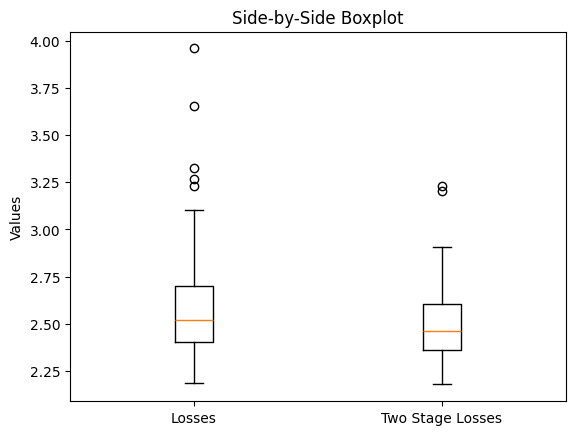

In [10]:
import matplotlib.pyplot as plt

data = [losses, two_stage_losses]
plt.boxplot(data, labels=['Losses', 'Two Stage Losses'])
plt.title('Side-by-Side Boxplot')
plt.ylabel('Values')
plt.show()

In [11]:
print(np.mean(losses))
print(np.std(losses))  # Standard deviation
print(np.mean(two_stage_losses))
print(np.std(two_stage_losses))  # Standard deviation
print(np.mean(nbp))
print(np.std(nbp))  # Standard deviation

2.589860598839248
0.2991649522275855
2.4968385031324267
0.19721093342768994
90.2
164.6394849360262


In [12]:
from scipy import stats

t_statistic, p_value = stats.ttest_rel(losses, two_stage_losses)


In [13]:
p_value

2.072596276350502e-05